# Generierung eigener Rhythmen basierend auf Datenanalyse von Schlagzeug Sequenzen durch Markov-Ketten 
### Generating unique rhythms based upon data analysis of drum loops by using Markov chains

Schlagzeug Sequenzen, sogenannte Drum-Loops, sind ein beliebtes Tool in der Musikindustrie: Interpreten können mithilfe dieser Loops selbst Demos erstellen oder ganze Stücke produzieren. Jedoch gestaltet sich die Auswahl als schwierig, wenn man kein versierter Schlagzeuger ist und kaum unterschiedlichen Stilistiken kennt. Das Ziel dieser Arbeit ist es dieses Problem zu lösen und die Auswahl von Schlagzeug Sequenzen zu vereinfachen. Es wird eine Datenbank aus Schlagzeug-Sequenzen erstellt und ein Programm welches diese Sequenzen verarbeitet und mithilfe von Markov-Ketten und des Viterbi-Algorithmus basierend auf der Datenbank künstliche Sequenzen generieren kann. Das [Essentia Framework](https://essentia.upf.edu/) dient hierbei als Grundlage.

Zu allererst importieren wir die benötigten Frameworks:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install drive/My\ Drive/markov_groove/markov_groove-0.1.0-py3-none-any.whl

In [3]:
!pip install nptyping watermark

     |████████████████████████████████| 51kB 2.6MB/s 


In [4]:
import markov_groove as mg
from pomegranate import DiscreteDistribution, HiddenMarkovModel, utils
from pretty_midi import PrettyMIDI
import IPython
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path
sns.set(style="darkgrid")


%load_ext watermark
%watermark -m -n -p numpy,scipy,pomegranate,essentia,markov_groove
print("GPU support is enabled!" if utils.is_gpu_enabled() else "GPU support is not enabled :(")

Wed Sep 09 2020 

numpy 1.18.2
scipy 1.4.1
pomegranate 0.13.4
essentia 2.1b6.dev234
markov_groove 0.1.0

compiler   : GCC 8.4.0
system     : Linux
release    : 4.19.112+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
GPU support is enabled!


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Einlesen der Dateien

Nun lesen wir die Dateien ein und definieren unsere Parameter:

In [19]:
# Definiere Parameter:
disco = mg.util.read_audio_files("drive/My Drive/markov_groove/disco", "*/*.*")
techno = mg.util.read_audio_files("drive/My Drive/markov_groove/techno", "*/*.*")
ballad_mid = mg.util.read_midi_files("drive/My Drive/markov_groove/mid_loop/Ballads", "*.mid")
bpm = 125
beats = 8
steps = 128

disco_sequencers, disco_samples = mg.util.create_knowledge_base(
    disco, mg.OnsetAlgorithm.COMPLEX, beats, steps
)
techno_sequencers, techno_samples = mg.util.create_knowledge_base(
    techno, mg.OnsetAlgorithm.COMPLEX, beats, steps
)

ballad_sequencers = [mg.MidiSequencer.from_file(mid) for mid in ballad_mid]

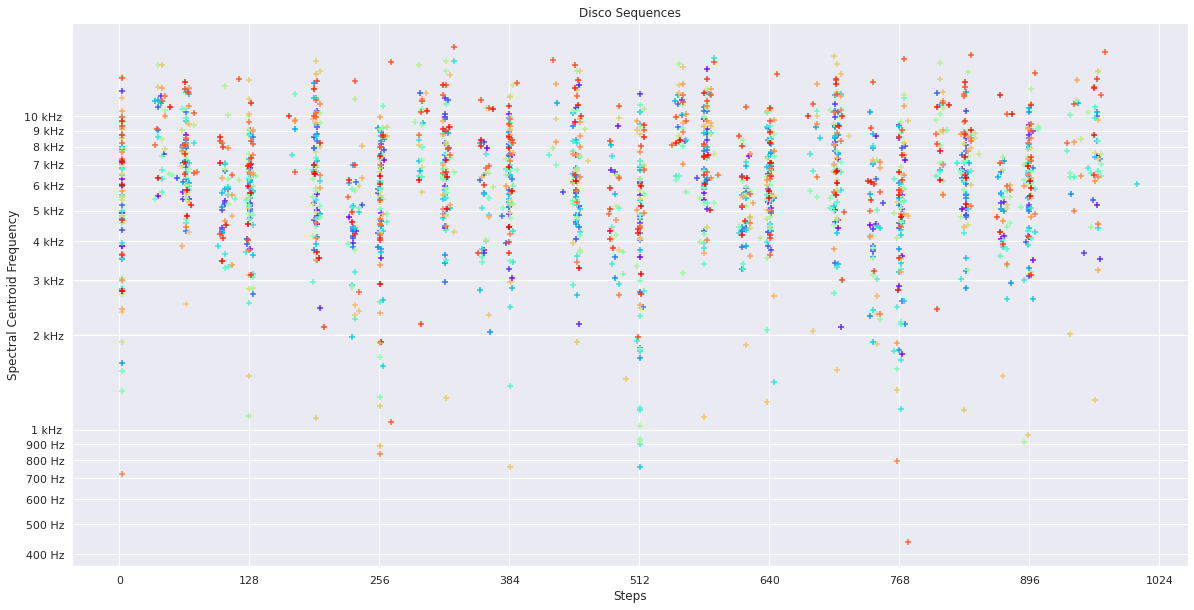

In [20]:
# Plot all disco sequences
colors = cm.rainbow(np.linspace(0, 1, len(disco_sequencers)))
_, ax = plt.subplots(figsize=(20, 10))
for sequencer, color in zip(disco_sequencers, colors):
    sequencer.visualize(ax, color)
plt.title("Disco Sequences")
plt.ylabel("Spectral Centroid Frequency")
plt.xlabel("Steps")
plt.show()
# print(f"Zeige {len(disco_sequencers)} Sequenzen. Insgesamt {len(disco_samples)} Samples.")

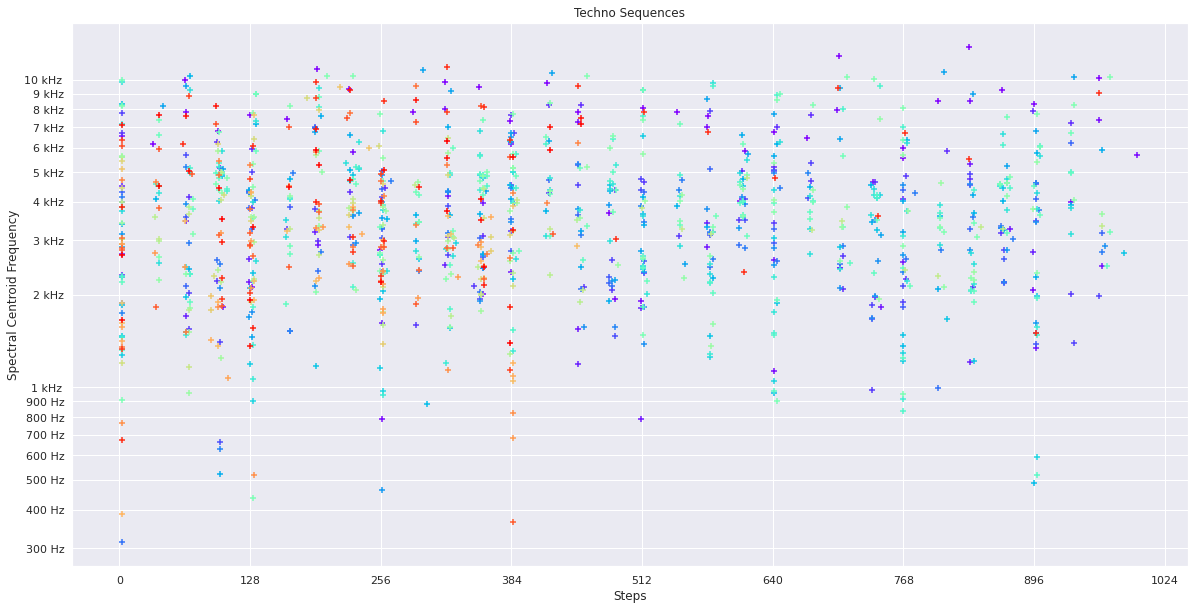

In [21]:
# Plot all techno sequences
colors = cm.rainbow(np.linspace(0, 1, len(techno_sequencers)))
_, ax = plt.subplots(figsize=(20, 10))
for sequencer, color in zip(techno_sequencers, colors):
    sequencer.visualize(ax, color)
plt.title("Techno Sequences")
plt.ylabel("Spectral Centroid Frequency")
plt.xlabel("Steps")
plt.show()
# print(f"Zeige {len(techno_sequencers)} Sequenzen. Insgesamt {len(techno_samples)} Samples.")

TypeError: ignored

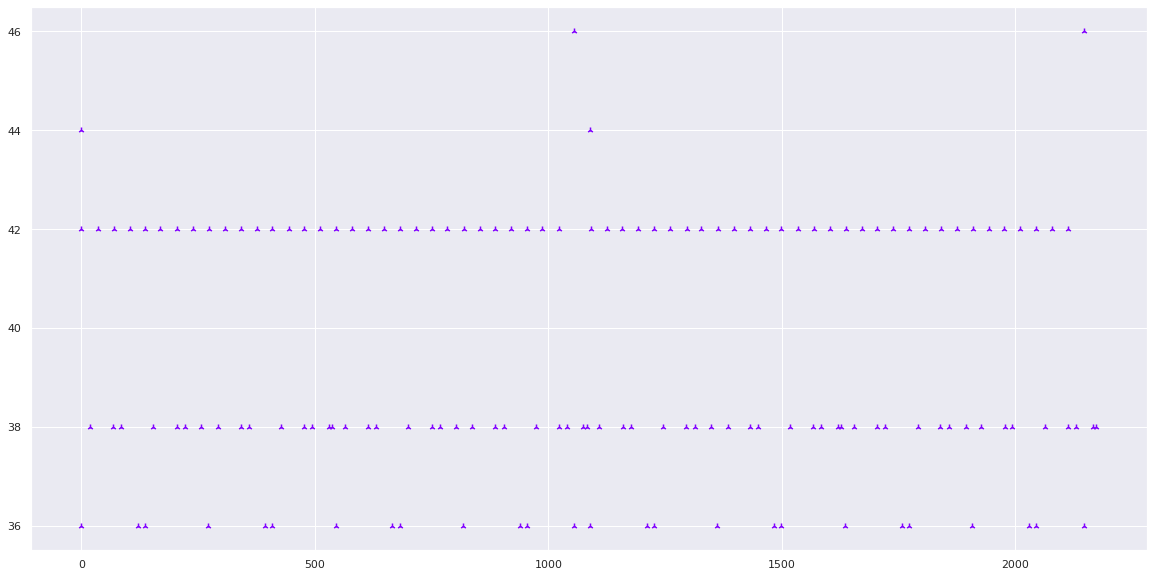

In [22]:
# Plot all ballad sequences
colors = cm.rainbow(np.linspace(0, 1, len(ballad_sequencers)))
_, ax = plt.subplots(figsize=(20, 10))
for sequencer, color in zip(ballad_sequencers, colors):
    sequencer.visualize(ax, color)
plt.title("Ballad Sequences")
plt.xlabel("Steps")
plt.yticks(range(35, 82))
plt.show()

Nun intialisieren das Generative Model:

In [23]:
disco_hidden_model = HiddenMarkovModel.from_samples(
    DiscreteDistribution,
    n_components=8,
    X=[seq.encode() for seq in disco_sequencers],
    name="disco",
    verbose=True,
)
techno_hidden_model = HiddenMarkovModel.from_samples(
    DiscreteDistribution,
    n_components=8,
    X=[seq.encode() for seq in techno_sequencers],
    name="techno",
    verbose=True,
)
ballad_hidden_model = HiddenMarkovModel.from_samples(
    DiscreteDistribution,
    n_components=8,
    X=[seq.encode() for seq in ballad_sequencers],
    name="ballad",
    verbose=True,
)

print("Alle Modelle wurden initialisiert und trainiert!")


[1] Improvement: 380297.16488996847	Time (s): 0.9306
[2] Improvement: 29.588448612601496	Time (s): 0.9333
[3] Improvement: 52.40619440062437	Time (s): 0.9356
[4] Improvement: 69.47213142586406	Time (s): 0.9314
[5] Improvement: 70.2801563028479	Time (s): 0.934
[6] Improvement: 72.09533823409583	Time (s): 0.9315
[7] Improvement: 97.9148994697025	Time (s): 0.9283
[8] Improvement: 165.5188948950963	Time (s): 0.9212
[9] Improvement: 293.61021908558905	Time (s): 0.9224
[10] Improvement: 546.7189649245702	Time (s): 0.9222
[11] Improvement: 1100.0896249135258	Time (s): 0.9379
[12] Improvement: 2463.4901056480594	Time (s): 0.9294
[13] Improvement: 5935.595425729873	Time (s): 0.9241
[14] Improvement: 12699.235632023308	Time (s): 0.9171
[15] Improvement: 20642.490874225157	Time (s): 0.9069
[16] Improvement: 26585.027423206833	Time (s): 0.8775
[17] Improvement: 24409.865893081354	Time (s): 0.8469
[18] Improvement: 12743.053685756167	Time (s): 0.8311
[19] Improvement: 5385.266319386312	Time (s): 0.

In [29]:
!apt install fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (1.1.9-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [31]:
!pip install pyfluidsynth

In [30]:
# Genriere neue Sequenz mit HMM
disco_hidden_sequence = disco_hidden_model.sample(length=beats * steps+1)
techno_hidden_sequence = techno_hidden_model.sample(length=beats * steps+1)
ballad_hidden_sequence = ballad_hidden_model.sample(length=3000)
print("HMM Sequenzen wurden generiert!")

# Kreiere neue Sequencer
new_disco_seq =  mg.AudioSequencer.decode(disco_hidden_sequence, bpm, beats, steps)
new_disco_beat_samples = [disco_samples[freq] for _, freq in new_disco_seq.pattern if not np.isnan(freq)]

new_techno_seq =  mg.AudioSequencer.decode(techno_hidden_sequence, bpm, beats, steps)
new_techno_beat_samples = [techno_samples[freq] for _, freq in new_techno_seq.pattern if not np.isnan(freq)]

new_ballad_seq = mg.MidiSequencer.decode(ballad_hidden_sequence)

# Kreiere neue Schlagzeugsequenzen
disco_beat =  new_disco_seq.create_beat(samples=new_disco_beat_samples)
techno_beat =  new_techno_seq.create_beat(samples=new_techno_beat_samples)
ballad_beat = new_ballad_seq.create_beat()
print("Schlagzeugsequenzen erstellt!")

HMM Sequenzen wurden generiert!


ImportError: ignored

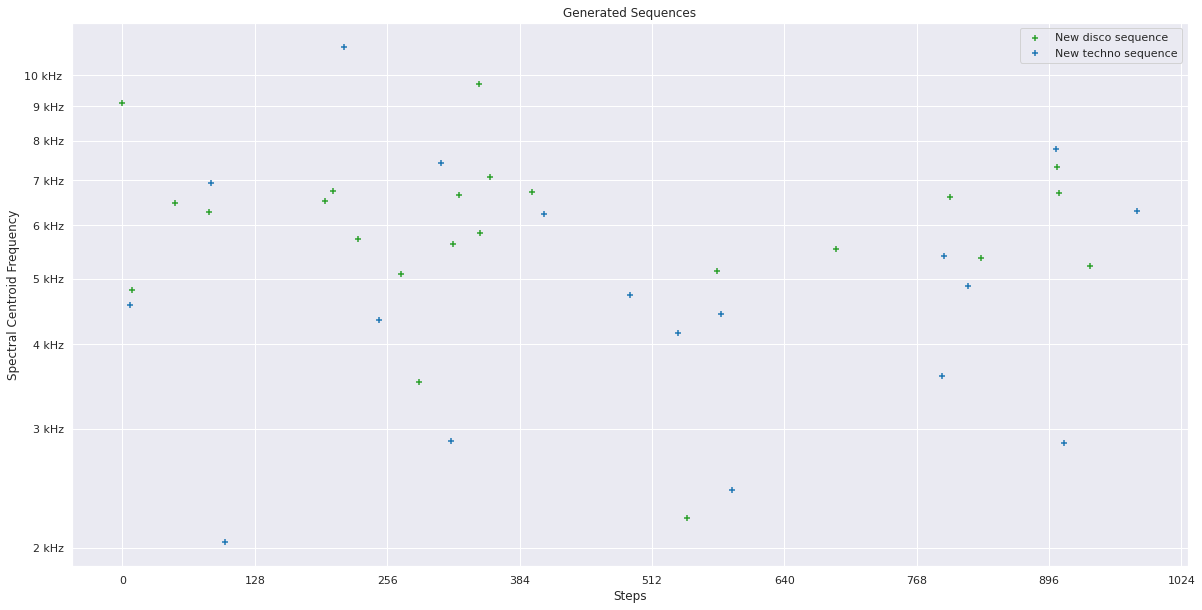

In [32]:
# Plot newly created sequences
_, ax = plt.subplots(figsize=(20, 10))
new_disco_seq.visualize(ax, "tab:green")
new_techno_seq.visualize(ax, "tab:blue")
ax.legend(["New disco sequence", "New techno sequence"])
plt.title("Generated Sequences")
plt.ylabel("Spectral Centroid Frequency")
plt.xlabel("Steps")
plt.show()

TypeError: ignored

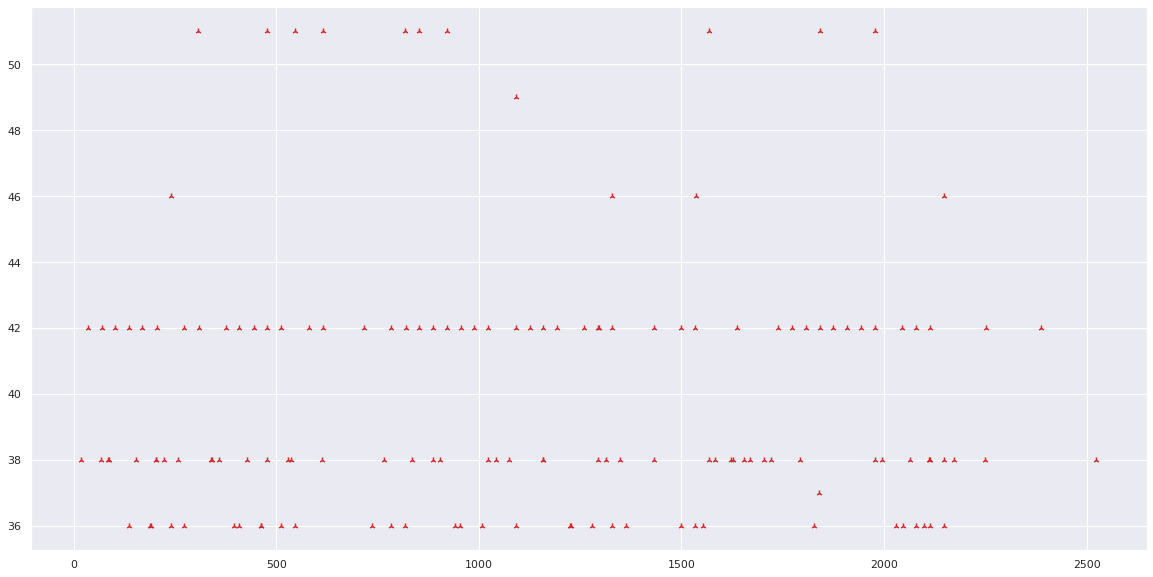

In [33]:
# Plot newly created sequences
_, ax = plt.subplots(figsize=(20, 10))
new_ballad_seq.visualize(ax, "tab:red")
ax.legend(["New ballad sequence"])
plt.title("Generated Sequences")
plt.xlabel("Steps")
plt.yticks(range(35, 82))
plt.show()

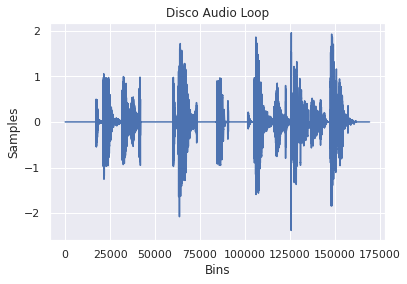

In [34]:
plt.plot(disco_beat.audio)
plt.title("Disco Audio Loop")
plt.ylabel("Samples")
plt.xlabel("Bins")
plt.show()

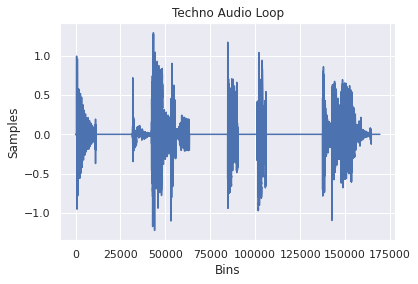

In [35]:
plt.plot(techno_beat.audio)
plt.title("Techno Audio Loop")
plt.ylabel("Samples")
plt.xlabel("Bins")
plt.show()

In [36]:
plt.plot(ballad_beat.audio)
plt.title("Ballad Audio Loop")
plt.ylabel("Samples")
plt.xlabel("Bins")
plt.show()

NameError: ignored

In [ ]:
disco_beat.save(Path(".temp/disco_audio.wav"))
techno_beat.save(Path(".temp/techno_audio.wav"))
ballad_beat.save(Path(".temp/ballad_audio.wav"))
print("Dateien abgespeichert!")

Dateien abgespeichert!


In [37]:
disco_beat.display()

In [38]:
techno_beat.display()

In [ ]:
ballad_beat.display()